In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**0. Oserwacje z pierwszego zadania**

Przydatne było oczyszczenie danych, uzupełnienie braków, zakodowanie cech kategorialnych i dodanie nowych kolumn, a mniej użyteczne – wizualizacje cech bez związku z klasą docelową

**1. Pobieranie i przygotowywanie danych**

import bibliotek

In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt



Transformacja(konwertacja obrazów na tensory oraz normalizacja pikseli) i normalizacja(standaryzacja)

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_part = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testing_part = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print('Rozmiar części treningowej: ', len(train_part))
print('Rozmiar części testowej: ', len(testing_part))


100%|██████████| 9.91M/9.91M [00:00<00:00, 140MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 51.4MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 92.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.48MB/s]


Rozmiar części treningowej:  60000
Rozmiar części testowej:  10000


Podzia części treningowej na dwie (val i train)

In [5]:
train_size = int(len(train_part) * 0.8)
val_size = len(train_part) - train_size
training_part, validation_part = random_split( train_part, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print('Rozmiar nowej części treningowej: ', len(training_part))
print('Rozmiar części walidacyjnej: ', len(validation_part))

Rozmiar nowej części treningowej:  48000
Rozmiar części walidacyjnej:  12000


DataLoaders: pakują po 64 elementy w batchy

In [6]:
BATCH_SIZE = 64
training_loader = DataLoader(training_part, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
validation_loader   = DataLoader(validation_part, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
testing_loader  = DataLoader(testing_part, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Wizualizacja 5 obrazów z datasetu wraz z odpowiadającymi im etykietami

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


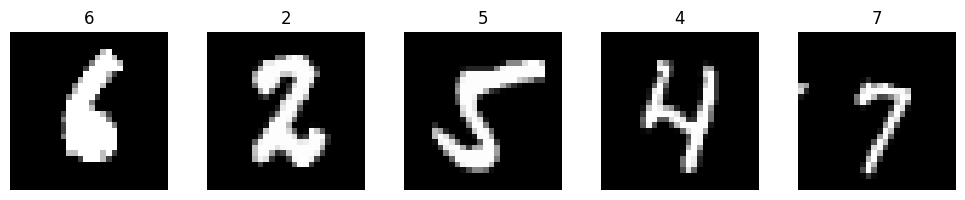

In [7]:
examples = enumerate(training_loader)
batch_idx, (example_data, example_targets) = next(examples)

figure, axes = plt.subplots(1, 5, figsize=(10, 2))
for elem in range(5):
    axes[elem].imshow(example_data[elem][0], cmap='gray')
    axes[elem].set_title(example_targets[elem].item())
    axes[elem].axis('off')

plt.tight_layout()
plt.show()

**2. Beseline**

Import bibliotek

In [8]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Definicja prostej sieci neuronowej

In [9]:
class MyBaseline(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(MyBaseline, self).__init__()
    self.input_size = input_size
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = x.view(-1, self.input_size)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

Tworzenie i podgląd struktury sn

In [10]:
inp = 28*28
hidden = 128
outp = 10

myBaseline = MyBaseline(inp, hidden, outp)
print(myBaseline)

MyBaseline(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Przenoszenie modelu na cuda, jeżeli cuda nie jest dostępne, to na cpu

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
myBaseline.to(device)


MyBaseline(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Optimalizator i funkcja straty

In [12]:
optimizer = optim.Adam(myBaseline.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


Trening modelu i obliczanie accuracy i average loss na zbiorach treningowym i validacyjnym

In [13]:
import time
epochs = 5
train_part_losses = []
validation_part_losses = []
train_part_accuracies = []
validation_part_accuracies = []
start_time = time.time()

for elem in range(epochs):
  myBaseline.train()
  train_part_loss = 0.0
  train_part_correct = 0
  train_part_total = 0

  for batch_idx, (data, target) in enumerate(training_loader):
    optimizer.zero_grad()
    output = myBaseline(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_part_loss += loss.item()
    _, predicted = torch.max(output.data, 1)
    train_part_total += target.size(0)
    train_part_correct += (predicted == target).sum().item()

  average_epoche_loss = train_part_loss / len(training_loader)
  train_part_losses.append(round(average_epoche_loss, 2))
  train_part_accuracy = 100 * train_part_correct / train_part_total
  train_part_accuracies.append(round(train_part_accuracy, 2))

  myBaseline.eval()
  validation_part_loss = 0.0
  validation_part_correct = 0
  validation_part_total = 0

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(validation_loader):
      output = myBaseline(data)
      loss = criterion(output, target)
      validation_part_loss += loss.item()
      _, predicted = torch.max(output.data, 1)
      validation_part_total += target.size(0)
      validation_part_correct += (predicted == target).sum().item()

  average_validation_loss = validation_part_loss / len(validation_loader)
  validation_part_losses.append(round(average_validation_loss, 2))
  validation_part_accuracy = 100 * validation_part_correct / validation_part_total
  validation_part_accuracies.append(round(validation_part_accuracy, 2))

  print('Average loss for epoche ', elem+1, ': ', round(average_epoche_loss, 2))
  print('Accuracy for epoche ', elem+1, ': ', round(train_part_accuracy, 2), '%')
  print('Average validation loss for epoche ', elem+1, ': ', round(average_validation_loss, 2))
  print('Validation accuracy for epoche ', elem+1, ': ', round(validation_part_accuracy, 2), '%')

print('Total training time: ', round(time.time()-start_time), ' sec')

Average loss for epoche  1 :  0.27
Accuracy for epoche  1 :  92.05 %
Average validation loss for epoche  1 :  0.17
Validation accuracy for epoche  1 :  95.03 %
Average loss for epoche  2 :  0.12
Accuracy for epoche  2 :  96.38 %
Average validation loss for epoche  2 :  0.13
Validation accuracy for epoche  2 :  96.18 %
Average loss for epoche  3 :  0.09
Accuracy for epoche  3 :  97.35 %
Average validation loss for epoche  3 :  0.11
Validation accuracy for epoche  3 :  96.95 %
Average loss for epoche  4 :  0.06
Accuracy for epoche  4 :  98.04 %
Average validation loss for epoche  4 :  0.1
Validation accuracy for epoche  4 :  97.03 %
Average loss for epoche  5 :  0.05
Accuracy for epoche  5 :  98.34 %
Average validation loss for epoche  5 :  0.11
Validation accuracy for epoche  5 :  96.92 %
Total training time:  85  sec


Wizualizacje accuracy i average loss na zbiorach treningowym i validacyjnym

In [14]:
def visualization(datta, label, title, label1, label2):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 6), datta, marker='o', label=label)
    plt.title(title)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.legend()
    plt.grid(True)
    plt.show()

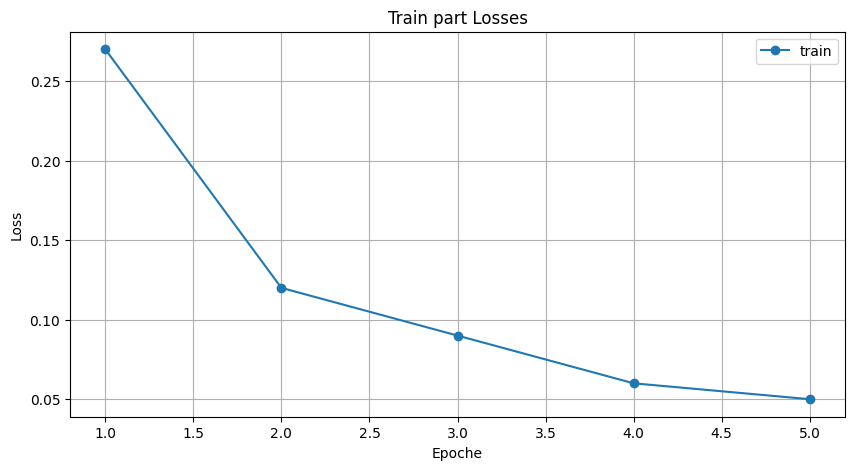

In [15]:
visualization(train_part_losses, 'train', 'Train part Losses', 'Epoche', 'Loss')

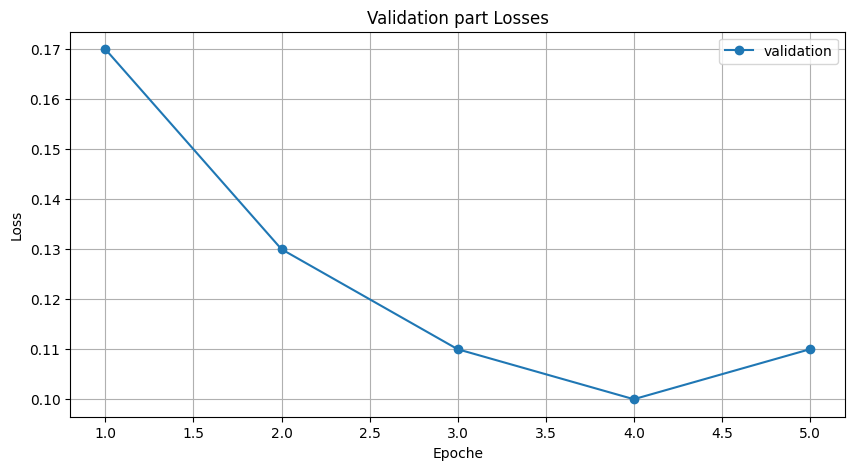

In [16]:
visualization(validation_part_losses, 'validation', 'Validation part Losses', 'Epoche', 'Loss')

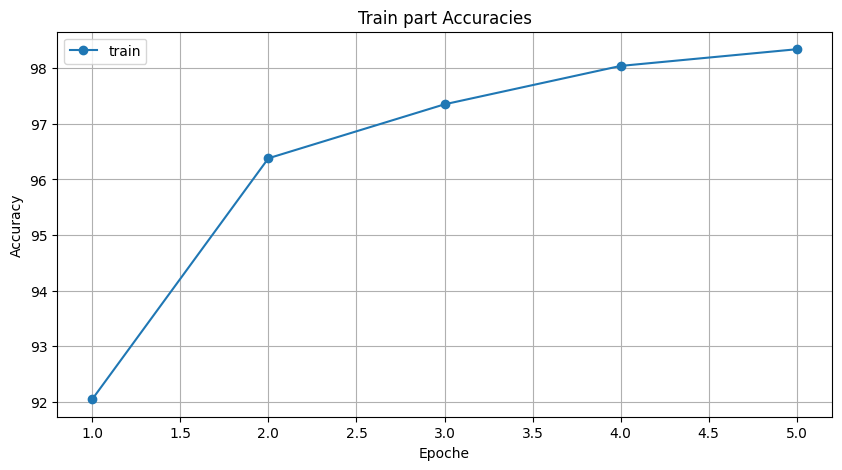

In [17]:
visualization(train_part_accuracies, 'train', 'Train part Accuracies', 'Epoche', 'Accuracy')

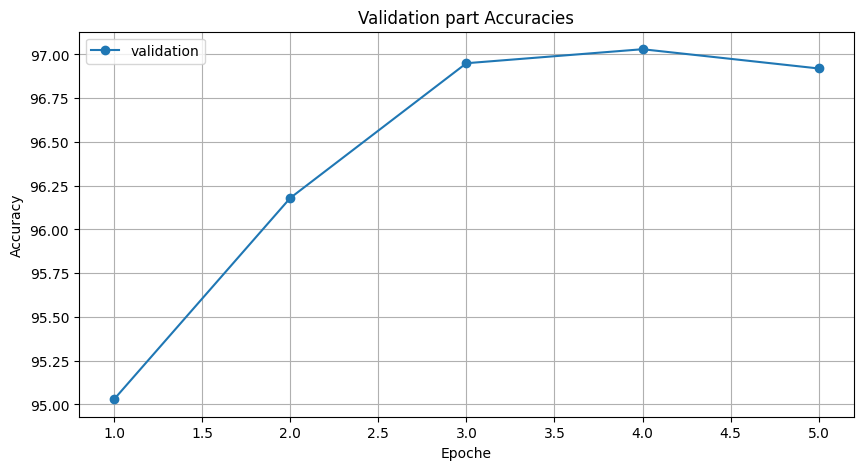

In [18]:
visualization(validation_part_accuracies, 'validation', 'Validation part Accuracies', 'Epoche', 'Accuracy')

Oblicznie accuracy i average loss dla zbioru testowego

In [19]:
test_part_loss = 0.0
test_part_correct = 0
test_part_total = 0

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(testing_loader):
        output = myBaseline(data)
        loss = criterion(output, target)
        test_part_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        test_part_total += target.size(0)
        test_part_correct += (predicted == target).sum().item()

average_test_loss = test_part_loss / len(testing_loader)
test_part_accuracy = 100 * test_part_correct / test_part_total

print('Average test loss: ', round(average_test_loss, 2))
print('Test accuracy: ', round(test_part_accuracy, 2), '%')

Average test loss:  0.09
Test accuracy:  97.56 %


Tworzenie macierzy zamieszania

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def vis_confusion_matrics(model, data_loader, title, labels= None, device=None):
  if device is not None:
        model.to(device)
  model.eval()
  predictions = []
  targets = []

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(data_loader):
      if device is not None:
        data, target = data.to(device), target.to(device)
      if hasattr(model, "conv1"):
        pass
      elif hasattr(model, "fc1"):
        data = data.view(data.size(0), -1)

      output = model(data)
      _, predicted = torch.max(output, 1)

      predictions.extend(predicted.cpu().numpy())
      targets.extend(target.cpu().numpy())

  if labels is None:
    labels = list(range(len(set(targets))))

  cm = confusion_matrix(targets, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="d")
  plt.title(title)
  plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


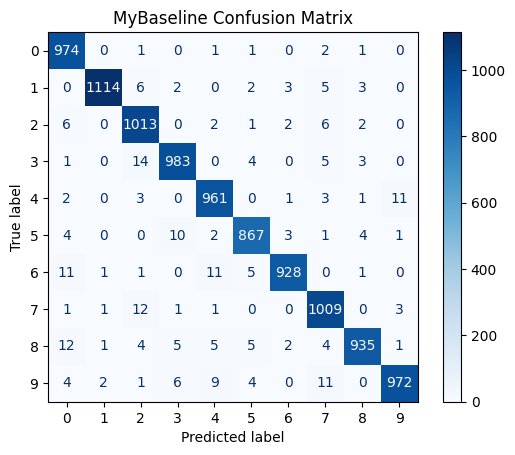

In [21]:
vis_confusion_matrics(model=myBaseline, data_loader=testing_loader, title="MyBaseline Confusion Matrix")


Mój baseline całkem dobrze rozróżnia liczby pisane: najgorzej rozróżnia 2,3,4, 5 i 9, najlepiej 1. 5 myli w większości z 8 i 9. 3 myli z 5, 8 i 9. Niekiedy 9 uważa za 4, 4 przyjmuje za 6 i 9, a  2 za 7.

**3. CNN**

Definicja CNN

In [22]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=10, conv1_channels=32, conv2_channels=64, dropout_prob=0.25, use_batchnorm=False):
      super().__init__()
      self.conv1 = nn.Conv2d(1, conv1_channels, kernel_size=3, padding=1)
      self.bn1 = nn.BatchNorm2d(conv1_channels) if use_batchnorm else nn.Identity()
      self.conv2 = nn.Conv2d(conv1_channels, conv2_channels, kernel_size=3, padding=1)
      self.bn2 = nn.BatchNorm2d(conv2_channels) if use_batchnorm else nn.Identity()
      self.pool = nn.MaxPool2d(2, 2)
      self.drop = nn.Dropout(dropout_prob)
      self.fc1 = nn.Linear(conv2_channels * 7 * 7, 128)
      self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
      x = self.pool(F.relu(self.bn1(self.conv1(x))))
      x = self.pool(F.relu(self.bn2(self.conv2(x))))
      x = self.drop(x)
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = self.drop(x)
      x = self.fc2(x)
      return x


Tworzenie i podgląd struktury CNN

In [23]:
myCnn = MyCNN().to(device)
print(myCnn)

MyCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): Identity()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): Identity()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Optymalizator i funkcja straty

In [24]:
from torch.optim import Adam

optimizer = Adam(myCnn.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()

Funkcja trenowania i walidacji



In [25]:
def run_one_epoch(loader, model, optimizer, loss_fn, train=True):
    cnn_total_loss = 0.0
    cnn_correct_preds = 0
    cnn_total_samples = 0

    model.train() if train else model.eval()

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            if train:
                loss.backward()
                optimizer.step()
        cnn_total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        cnn_correct_preds += (preds == labels).sum().item()
        cnn_total_samples += labels.size(0)

    cnn_average_loss = cnn_total_loss / cnn_total_samples
    cnn_accuracy = 100 * cnn_correct_preds / cnn_total_samples
    return cnn_average_loss, cnn_accuracy


Trenowanie/walidacja

In [26]:
cnn_epochs = 5
all_train_loss = []
all_train_acc = []
all_val_loss = []
all_val_acc = []
start_time = time.time()

for elem in range(1, epochs+1):
    tr_loss, tr_acc = run_one_epoch(training_loader, myCnn, optimizer, loss_function, train=True)
    val_loss, val_acc = run_one_epoch(validation_loader, myCnn, optimizer, loss_function, train=False)

    all_train_loss.append(tr_loss)
    all_train_acc.append(tr_acc)
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)

    print('Average loss for epoche ', elem, ': ', round(tr_loss, 2))
    print('Accuracy for epoche ', elem, ': ', round(tr_acc), '%')
    print('Average validation loss for epoche ', elem, ': ', round(val_loss, 2))
    print('Validation accuracy for epoche ', elem, ': ', round(val_acc), '%')

print('Total training time: ', round(time.time()-start_time), ' sec')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Average loss for epoche  1 :  0.2
Accuracy for epoche  1 :  94 %
Average validation loss for epoche  1 :  0.07
Validation accuracy for epoche  1 :  98 %
Average loss for epoche  2 :  0.07
Accuracy for epoche  2 :  98 %
Average validation loss for epoche  2 :  0.05
Validation accuracy for epoche  2 :  99 %
Average loss for epoche  3 :  0.05
Accuracy for epoche  3 :  98 %
Average validation loss for epoche  3 :  0.04
Validation accuracy for epoche  3 :  99 %
Average loss for epoche  4 :  0.04
Accuracy for epoche  4 :  99 %
Average validation loss for epoche  4 :  0.04
Validation accuracy for epoche  4 :  99 %
Average loss for epoche  5 :  0.04
Accuracy for epoche  5 :  99 %
Average validation loss for epoche  5 :  0.04
Validation accuracy for epoche  5 :  99 %
Total training time:  412  sec


Wizualizacja accuracy i loss

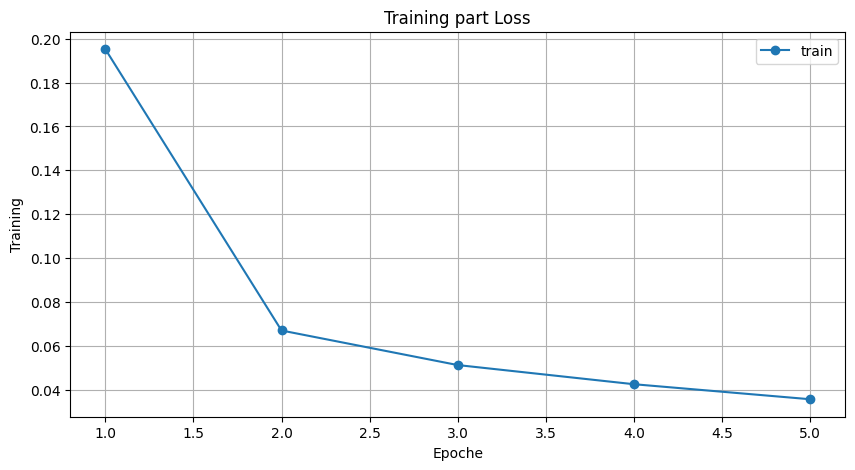

In [27]:
visualization(all_train_loss, 'train', 'Training part Loss', 'Epoche', 'Training')

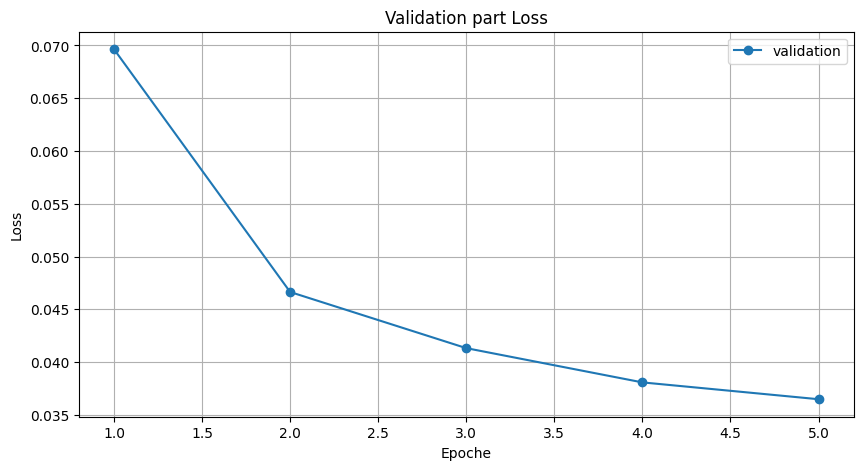

In [28]:
visualization(all_val_loss, 'validation', 'Validation part Loss', 'Epoche', 'Loss')

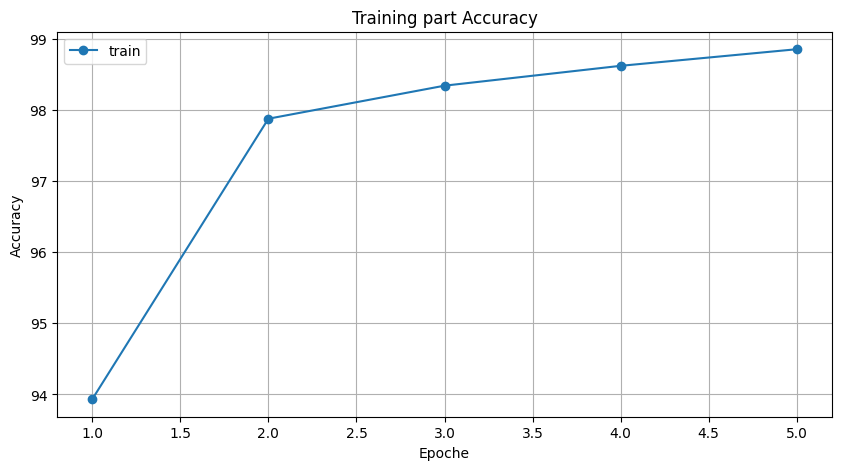

In [29]:
visualization(all_train_acc, 'train', 'Training part Accuracy', 'Epoche', 'Accuracy')

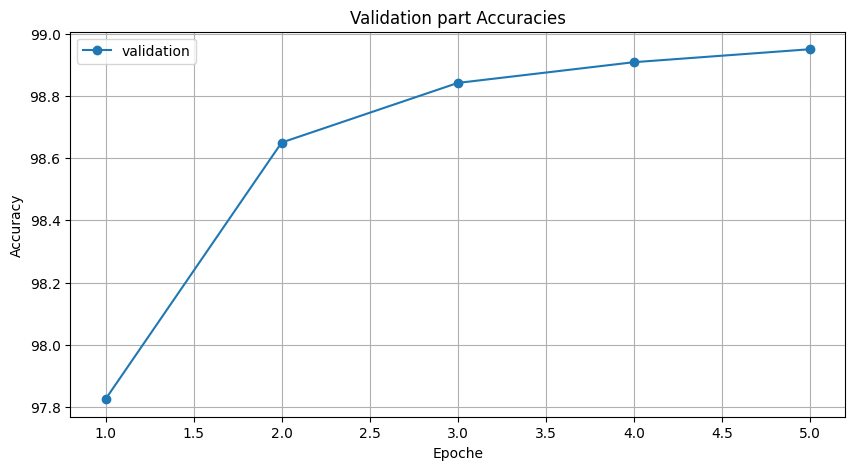

In [30]:
visualization(all_val_acc, 'validation', 'Validation part Accuracies', 'Epoche', 'Accuracy')

Wynik: dla każdej epochi wartości cnn są większe niż u mojego baseline, co juz jest dobrym znakiem. Liczba strat równiż jest mniejsza to znaczy, że cnn poprawniej rozróżnia napisane liczby. Ale czas, potrzebny na uczenie mojego baseline jest znacznie mniejszy niż dla cnn

Obliczanie accuracy i loss dla zbioru testowego

In [31]:
myCnn.eval()
cnn_test_loss = 0.0
cnn_test_correct = 0
cnn_test_total = 0
with torch.no_grad():
    for images, labels in testing_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = myCnn(images)
        loss = loss_function(outputs, labels)

        cnn_test_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        cnn_test_correct += (preds == labels).sum().item()
        cnn_test_total += labels.size(0)

cnn_test_loss /= cnn_test_total
test_acc = cnn_test_correct / cnn_test_total

print('Average test loss: ', round(cnn_test_loss, 2))
print('Test accuracy: ', round(test_acc*100, 2), '%')

Average test loss:  0.02
Test accuracy:  99.16 %


Wynik: na zbiorze testowym wynik też jest wiekszy w porównaniu z moim baseline. Straty są minimalne

Macież straty dla cnn

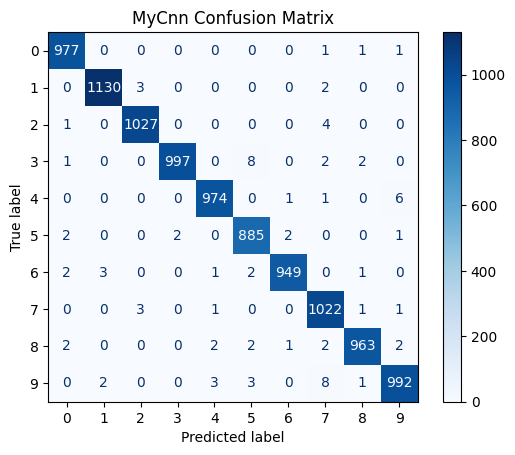

In [32]:
vis_confusion_matrics(model=myCnn, data_loader=testing_loader, title="MyCnn Confusion Matrix")

Wynik: z maciży widać, że cnn tez liepiej rozróżnia 1. 7 myli z 9. 9 myli z 4, a 5 też jest najgorsza w rozróżnieniu, myli 5 z 3. Ale straty są mniejsze i accuracy większa

**4. Wpływ parametrów na wynik końcowy (cnn)**

In [34]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=5, device=device):
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    model.to(device)
    start_time = time.time()

    for epoch in range(1, epochs+1):
        cnn_tr_loss, cnn_tr_acc = run_one_epoch(train_loader, model, optimizer, loss_fn, train=True)
        cnn_va_loss, ccn_va_acc = run_one_epoch(val_loader, model, optimizer, loss_fn, train=False)

        train_loss.append(cnn_tr_loss)
        train_acc.append(cnn_tr_acc)
        val_loss.append(cnn_va_loss)
        val_acc.append(ccn_va_acc)

        print('Average loss for epoche ', epoch, ': ', round(cnn_tr_loss, 2))
        print('Accuracy for epoche ', epoch, ': ', round(cnn_tr_acc), '%')
        print('Average validation loss for epoche ', epoch, ': ', round(cnn_va_loss, 2))
        print('Validation accuracy for epoche ', epoch, ': ', round(ccn_va_acc), '%')

    print('Total training time: ', round(time.time()-start_time), ' sec')

    return train_loss, train_acc, val_loss, val_acc

* Zwiększenie liczby kanlów

In [37]:
cnn2 = MyCNN(conv1_channels=64, conv2_channels=128, dropout_prob=0.25, use_batchnorm=False)
optimizer2 = torch.optim.Adam(cnn2.parameters(), lr=1e-3)

tr_loss2, tr_acc2, va_loss2, va_acc2 = train_model(cnn2, training_loader, validation_loader, optimizer2, loss_function, epochs=5)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Average loss for epoche  1 :  0.15
Accuracy for epoche  1 :  95 %
Average validation loss for epoche  1 :  0.05
Validation accuracy for epoche  1 :  98 %
Average loss for epoche  2 :  0.06
Accuracy for epoche  2 :  98 %
Average validation loss for epoche  2 :  0.05
Validation accuracy for epoche  2 :  98 %
Average loss for epoche  3 :  0.04
Accuracy for epoche  3 :  99 %
Average validation loss for epoche  3 :  0.04
Validation accuracy for epoche  3 :  99 %
Average loss for epoche  4 :  0.04
Accuracy for epoche  4 :  99 %
Average validation loss for epoche  4 :  0.03
Validation accuracy for epoche  4 :  99 %
Average loss for epoche  5 :  0.03
Accuracy for epoche  5 :  99 %
Average validation loss for epoche  5 :  0.03
Validation accuracy for epoche  5 :  99 %
Total training time:  961  sec


Wizualizacja

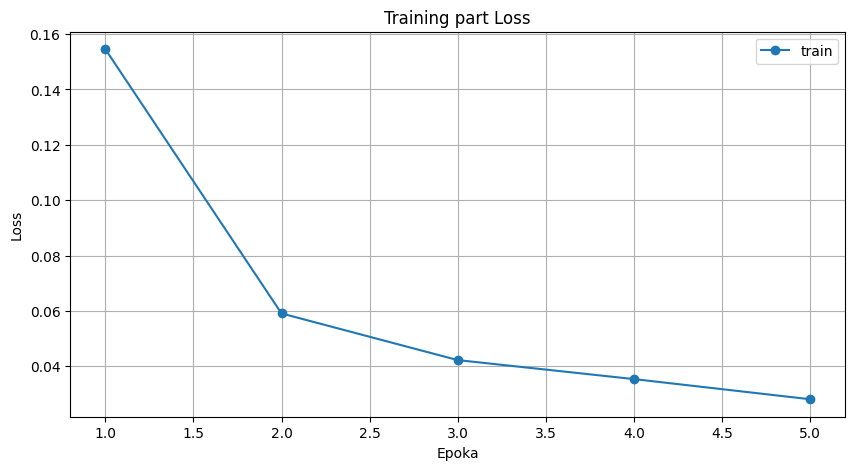

In [38]:
visualization(tr_loss2, 'train', 'Training part Loss', 'Epoka', 'Loss')

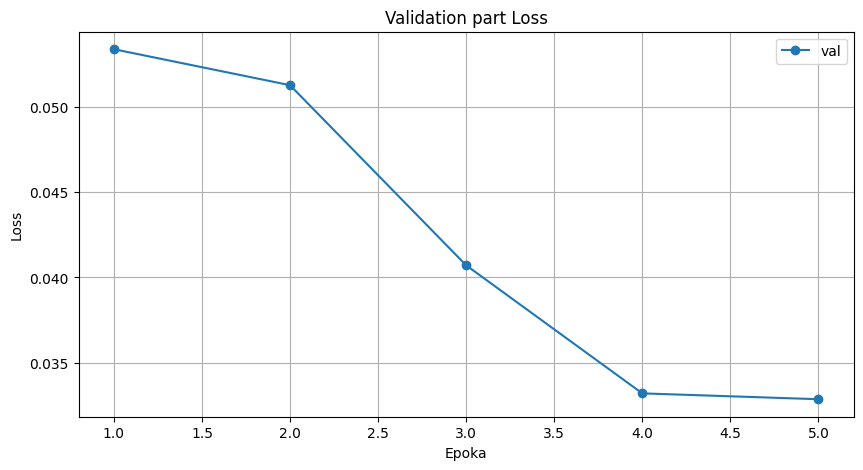

In [39]:
visualization(va_loss2, 'val', 'Validation part Loss', 'Epoka', 'Loss')

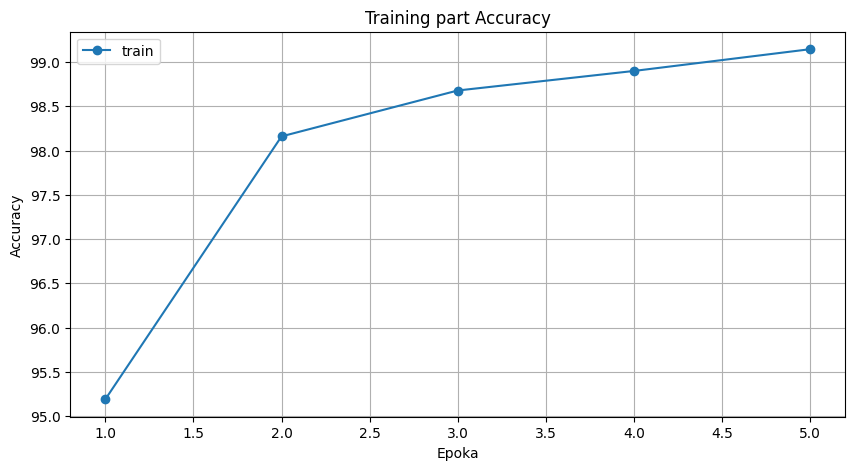

In [40]:
visualization(tr_acc2, 'train', 'Training part Accuracy', 'Epoka', 'Accuracy')

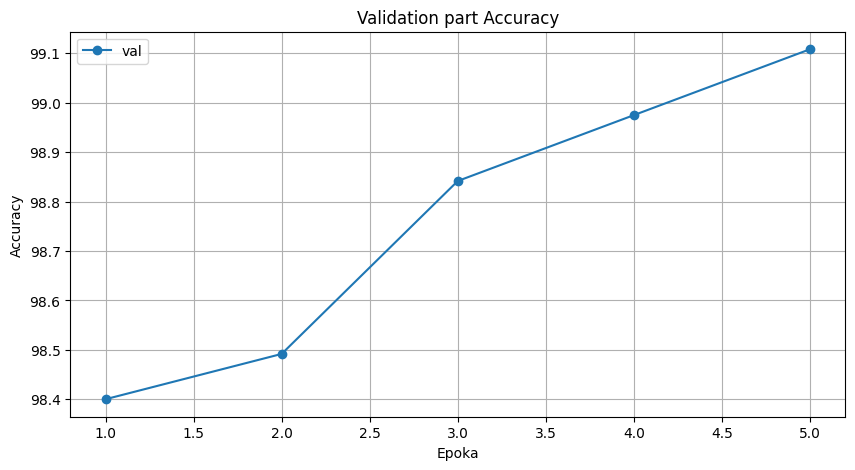

In [41]:
visualization(va_acc2, 'val', 'Validation part Accuracy', 'Epoka', 'Accuracy')

Wynik: zwiększenie liczby kanałów w warstwach konwolucyjnych poprawiło zdolność modelu do uczenia się cech. Już w pierwszej epoce dokładność treningowa osiągnęła 95%, a strata treningowa spadła do 0.15, natomiast strata walidacyjna wynosiła tylko 0.05 przy dokładności 98%.

Po pięciu epokach model osiągnął bardzo wysoką dokładność treningową i walidacyjną (99%) oraz niskie straty (0.03–0.04). Ale czas treningu znacznie się wydłużył (961 sekund), co wynika z większej liczby parametrów w sieci.

* Z wykorzystaniem BatchNorm

In [42]:
cnn3 = MyCNN(conv1_channels=32, conv2_channels=64, dropout_prob=0.25, use_batchnorm=True)
optimizer3 = torch.optim.Adam(cnn3.parameters(), lr=1e-3)

tr_loss3, tr_acc3, va_loss3, va_acc3 = train_model(cnn3, training_loader, validation_loader, optimizer3, loss_function, epochs=5)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Average loss for epoche  1 :  0.18
Accuracy for epoche  1 :  95 %
Average validation loss for epoche  1 :  0.07
Validation accuracy for epoche  1 :  98 %
Average loss for epoche  2 :  0.07
Accuracy for epoche  2 :  98 %
Average validation loss for epoche  2 :  0.05
Validation accuracy for epoche  2 :  98 %
Average loss for epoche  3 :  0.06
Accuracy for epoche  3 :  98 %
Average validation loss for epoche  3 :  0.04
Validation accuracy for epoche  3 :  99 %
Average loss for epoche  4 :  0.05
Accuracy for epoche  4 :  98 %
Average validation loss for epoche  4 :  0.04
Validation accuracy for epoche  4 :  99 %
Average loss for epoche  5 :  0.04
Accuracy for epoche  5 :  99 %
Average validation loss for epoche  5 :  0.04
Validation accuracy for epoche  5 :  99 %
Total training time:  542  sec


Wizualizacja

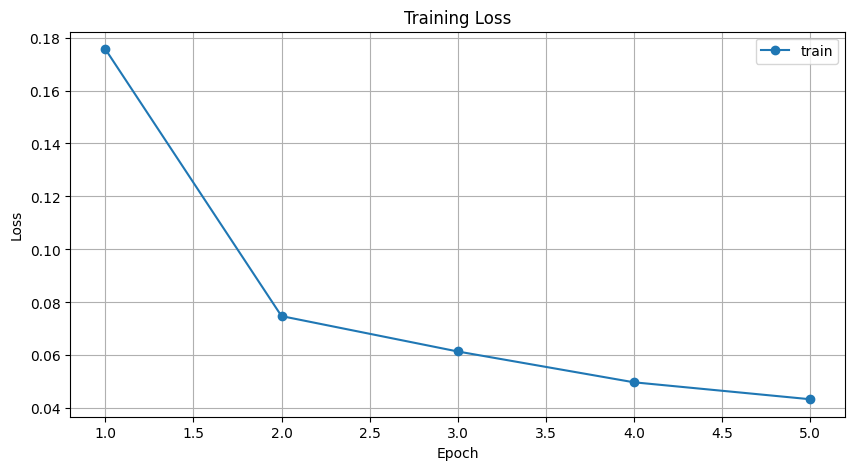

In [43]:
visualization(tr_loss3, 'train', 'Training Loss', 'Epoch', 'Loss')

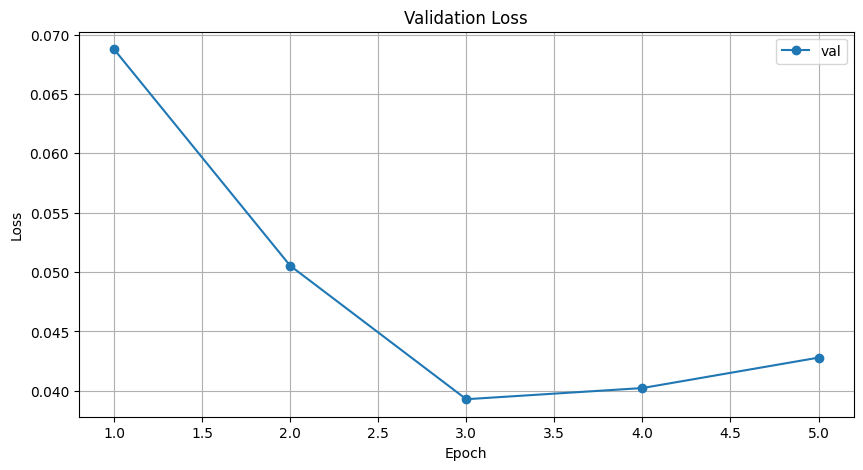

In [44]:
visualization(va_loss3, 'val', 'Validation Loss', 'Epoch', 'Loss')

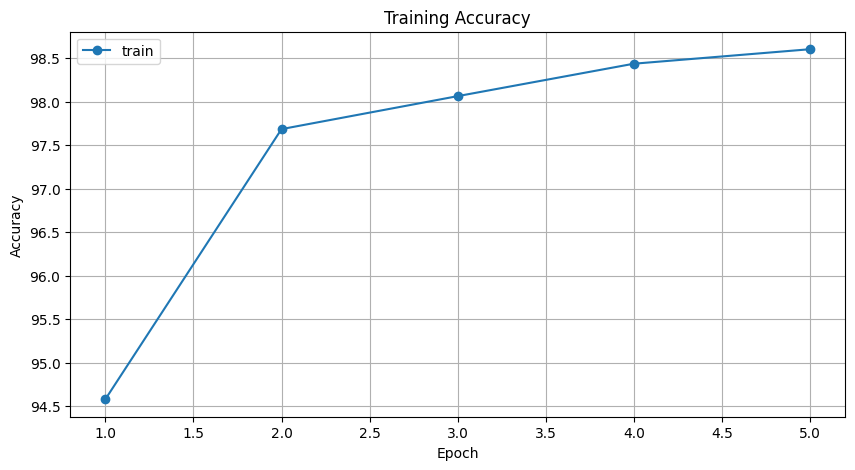

In [45]:
visualization(tr_acc3, 'train', 'Training Accuracy', 'Epoch', 'Accuracy')

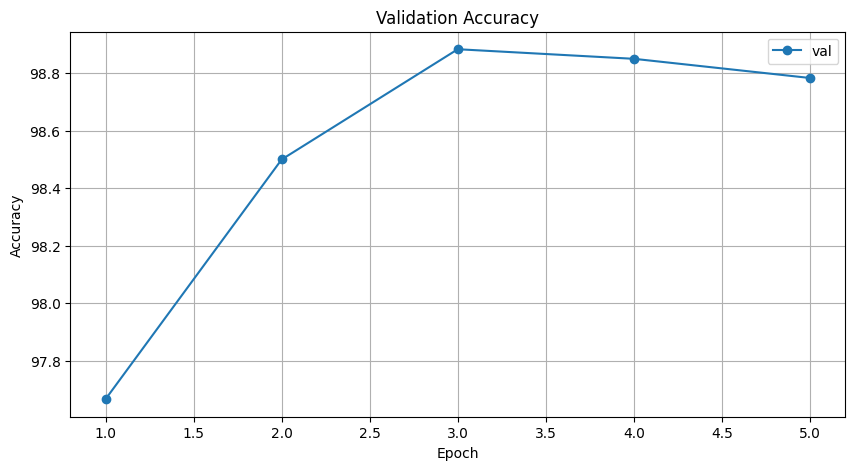

In [46]:
visualization(va_acc3, 'val', 'Validation Accuracy', 'Epoch', 'Accuracy')

Wynik: zwiększenie modelu o BatchNorm lekko poprawiło początkową dokładność treningową — w pierwszej epoce model osiągnął 95% dokładności zamiast 94% w modelu bazowym, a strata treningowa spadła do 0.18 zamiast 0.20. Straty i dokładność walidacyjne w pierwszych epokach pozostały praktycznie takie same.

Po pięciu epokach końcowa dokładność zarówno treningowa, jak i walidacyjna była identyczna jak w modelu bazowym, a końcowe straty również się nie zmieniły. Jedyną zauważalną różnicą jest dłuższy czas treningu — BatchNorm wydłużył go do 542 sekund w porównaniu do 412 sekund w modelu bazowym.

* Zwiększenie Dropout

In [47]:
cnn4 = MyCNN(conv1_channels=32, conv2_channels=64, dropout_prob=0.5, use_batchnorm=False)
optimizer4 = torch.optim.Adam(cnn4.parameters(), lr=1e-3)

tr_loss4, tr_acc4, va_loss4, va_acc4 = train_model(cnn4, training_loader, validation_loader, optimizer4, loss_function, epochs=5)

Average loss for epoche  1 :  0.27
Accuracy for epoche  1 :  92 %
Average validation loss for epoche  1 :  0.08
Validation accuracy for epoche  1 :  97 %
Average loss for epoche  2 :  0.11
Accuracy for epoche  2 :  97 %
Average validation loss for epoche  2 :  0.05
Validation accuracy for epoche  2 :  98 %
Average loss for epoche  3 :  0.09
Accuracy for epoche  3 :  97 %
Average validation loss for epoche  3 :  0.05
Validation accuracy for epoche  3 :  98 %
Average loss for epoche  4 :  0.08
Accuracy for epoche  4 :  98 %
Average validation loss for epoche  4 :  0.04
Validation accuracy for epoche  4 :  99 %
Average loss for epoche  5 :  0.07
Accuracy for epoche  5 :  98 %
Average validation loss for epoche  5 :  0.04
Validation accuracy for epoche  5 :  99 %
Total training time:  462  sec


Wizualizacja

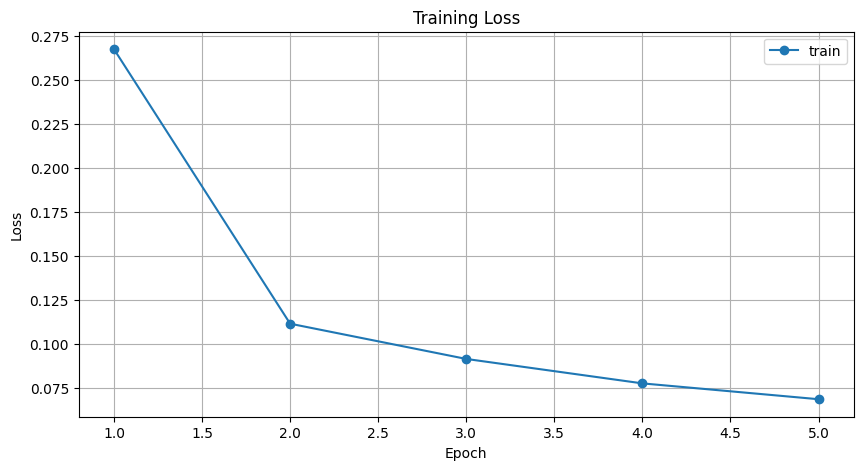

In [48]:
visualization(tr_loss4, 'train', 'Training Loss', 'Epoch', 'Loss')

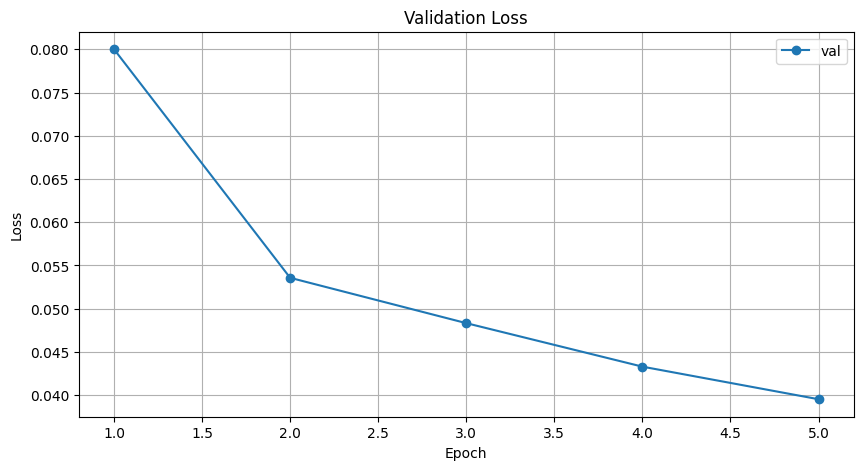

In [49]:
visualization(va_loss4, 'val', 'Validation Loss', 'Epoch', 'Loss')

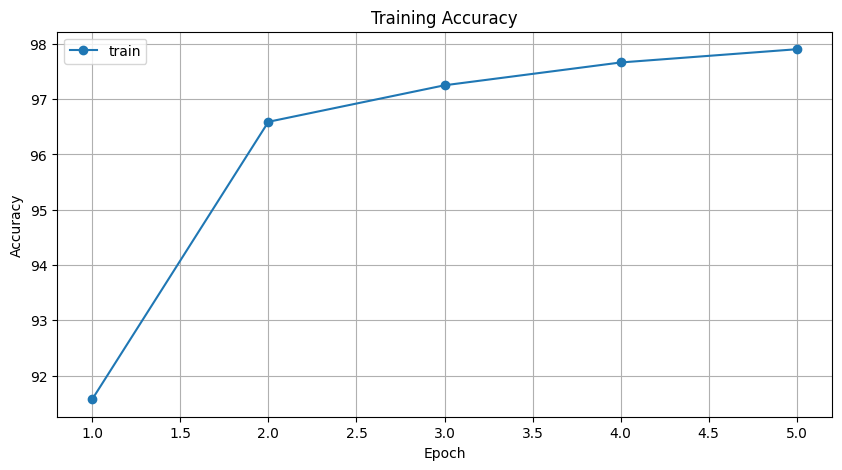

In [50]:
visualization(tr_acc4, 'train', 'Training Accuracy', 'Epoch', 'Accuracy')

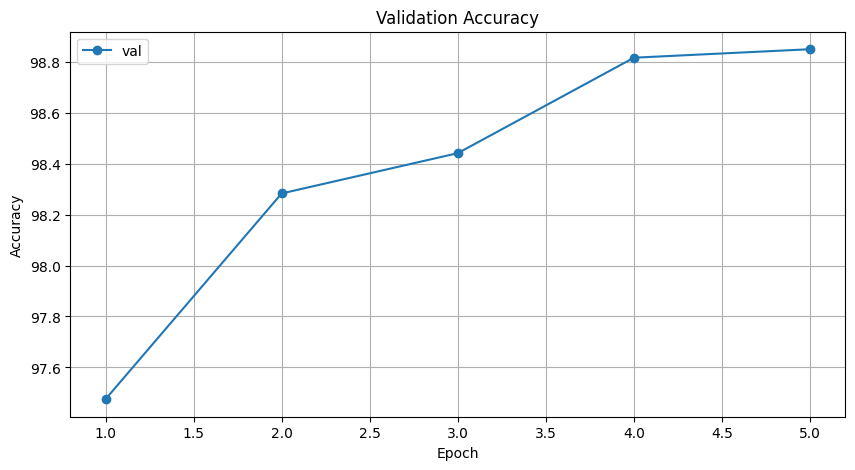

In [51]:
visualization(va_acc4, 'val', 'Validation Accuracy', 'Epoch', 'Accuracy')

Wynik: zwiększenie wartości dropoutu nie przyniosło znaczących korzyści — dokładność walidacyjna pozostała na bardzo podobnym poziomie (98–99%), natomiast trening przebiegał wolniej i model trudniej dopasowywał się do danych

* Zmniejszenie dropOut

In [52]:
cnn7 = MyCNN(conv1_channels=32, conv2_channels=64, dropout_prob=0.1, use_batchnorm=False)
optimizer7 = torch.optim.Adam(cnn7.parameters(), lr=1e-3)

tr_loss7, tr_acc7, va_loss7, va_acc7 = train_model(cnn7, training_loader, validation_loader, optimizer7, loss_function, epochs=5)

Average loss for epoche  1 :  0.17
Accuracy for epoche  1 :  95 %
Average validation loss for epoche  1 :  0.07
Validation accuracy for epoche  1 :  98 %
Average loss for epoche  2 :  0.06
Accuracy for epoche  2 :  98 %
Average validation loss for epoche  2 :  0.06
Validation accuracy for epoche  2 :  98 %
Average loss for epoche  3 :  0.04
Accuracy for epoche  3 :  99 %
Average validation loss for epoche  3 :  0.05
Validation accuracy for epoche  3 :  99 %
Average loss for epoche  4 :  0.03
Accuracy for epoche  4 :  99 %
Average validation loss for epoche  4 :  0.04
Validation accuracy for epoche  4 :  99 %
Average loss for epoche  5 :  0.02
Accuracy for epoche  5 :  99 %
Average validation loss for epoche  5 :  0.04
Validation accuracy for epoche  5 :  99 %
Total training time:  440  sec


Wizualizacja

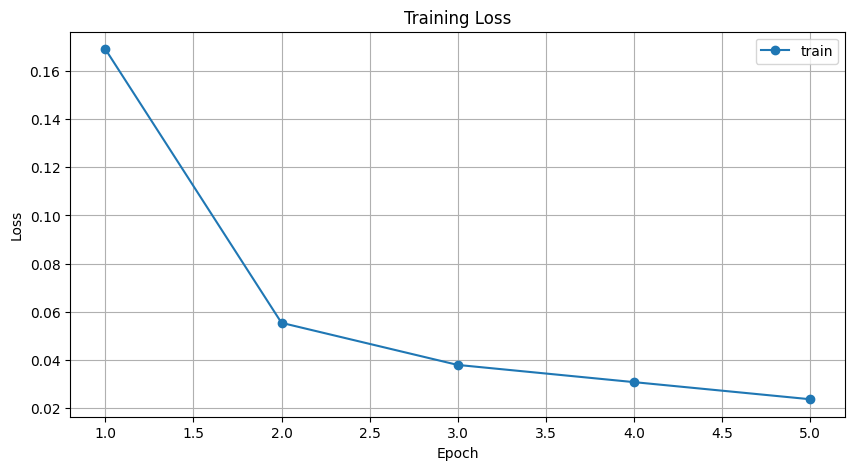

In [53]:
visualization(tr_loss7, 'train', 'Training Loss', 'Epoch', 'Loss')

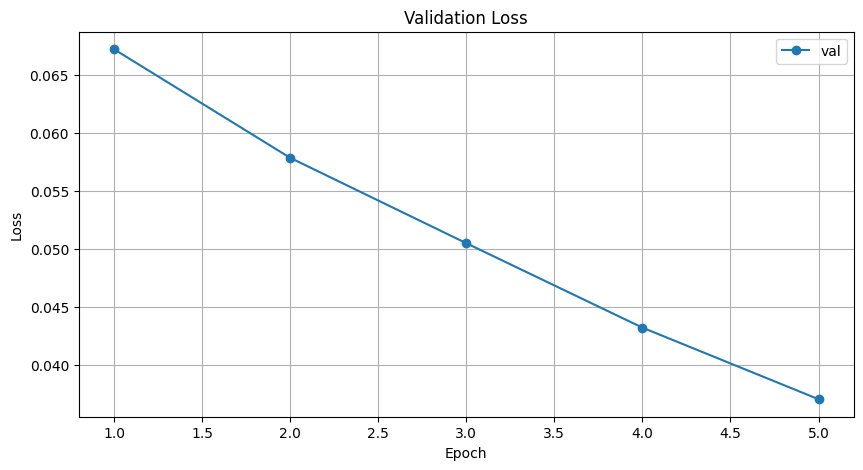

In [54]:
visualization(va_loss7, 'val', 'Validation Loss', 'Epoch', 'Loss')

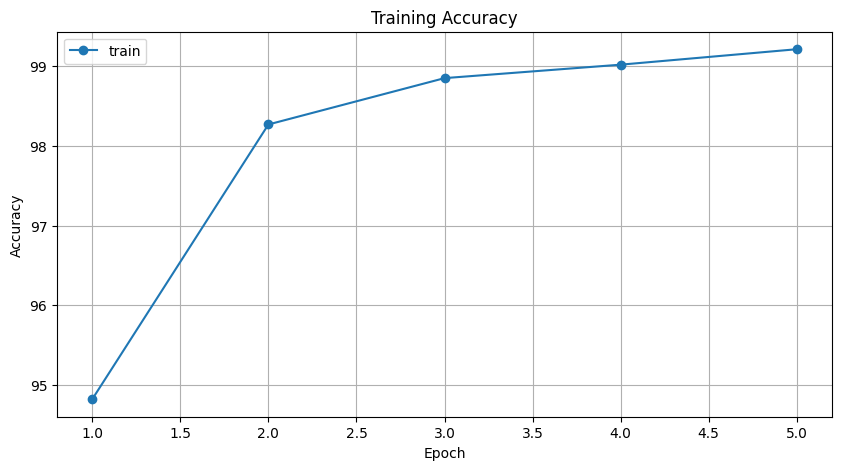

In [55]:
visualization(tr_acc7, 'train', 'Training Accuracy', 'Epoch', 'Accuracy')

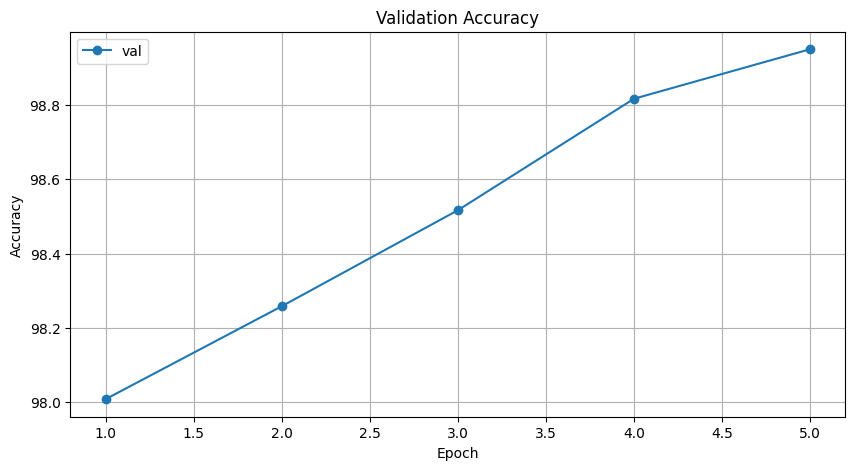

In [56]:
visualization(va_acc7, 'val', 'Validation Accuracy', 'Epoch', 'Accuracy')

Wynik: zmniejszenie wartości dropoutu do 0.1 poprawiło wyniki treningowe — w pierwszej epoce dokładność treningowa wzrosła do 95%, a strata treningowa spadła do 0.17. Strata i dokładność walidacyjna pozostały na bardzo dobrym poziomie od początku.

Po pięciu epokach model osiągnął bardzo wysoką dokładność treningową i walidacyjną (99%), a końcowe straty spadły do 0.02 dla treningu i 0.04 dla walidacji. Czas treningu był umiarkowany (440 sekund), krótszy niż przy BatchNorm, ale trochę dłuższy niż model bazowy.

**5. Wynik końcowy**

CNN działa znacznie lepiej niż mój baseline, osiągając wyższą dokładność i niższe straty zarówno na treningu, jak i walidacji.

Zmniejszenie dropoutu było korzystne — poprawiło dokładność treningową i przyspieszyło uczenie, przy zachowaniu dobrej generalizacji.

Zwiększenie liczby kanalów pozwoliło modelowi lepiej wyłapywać cechy, ale wydłużyło czas treningu.

Dodanie BatchNorm miało minimalny wpływ na końcową dokładność, jedynie stabilizowało początkowe epoki i wydłużało czas uczenia.

Zwiększanie dropoutu nie dawało korzyści — straty były wyższe, a dokładność treningowa niższa, przy praktycznie tej samej generalizacji.

Dodatkowo analiza macierzy pomyłek pokazała, że najtrudniej model rozpoznawał cyfry 3, 5 i 9. Najczęściej dochodziło do pomyłek między 3 a 5 oraz między 9 a 7, co wynika z podobnego kształtu tych cyfr w danych